In [1]:
# Let's make sure these directories are clean before we start
import shutil
try:
    shutil.rmtree("images-cnn-split/train")
    shutil.rmtree("images-cnn-split/test")
except:
    pass

In [2]:
# We have three class which contains all the data: Bread, Soup and Vegetable-Fruit
# Let's create directories for each class in the train and test directories.
import os
# ensure directories exist
from pathlib import Path

Path("images-cnn-split/train/damage").mkdir(parents=True, exist_ok=True)
Path("images-cnn-split/train/no_damage").mkdir(parents=True, exist_ok=True)
Path("images-cnn-split/test/damage").mkdir(parents=True, exist_ok=True)
Path("images-cnn-split/test/no_damage").mkdir(parents=True, exist_ok=True)


In [3]:
# we need paths of images for individual classes so we can copy them in the new directories that we created above
all_damage_file_paths = os.listdir('images/damage')
all_no_damage_file_paths = os.listdir('images/no_damage')

In [4]:
import random

train_damage_paths = random.sample(all_damage_file_paths, int(len(all_damage_file_paths)*0.8))
print("train damage image count: ", len(train_damage_paths))
test_damage_paths = [ p for p in all_damage_file_paths if p not in train_damage_paths]
print("test damage image count: ", len(test_damage_paths))
# ensure no overlap:
overlap = [p for p in train_damage_paths if p in test_damage_paths]
print("len of overlap: ", len(overlap))

train_no_damage_paths = random.sample(all_no_damage_file_paths, int(len(all_no_damage_file_paths)*0.8))
print("train no_damage image count: ", len(train_no_damage_paths))
test_no_damage_paths = [ p for p in all_no_damage_file_paths if p not in train_no_damage_paths]
print("test no_damage image count: ", len(test_no_damage_paths))
# ensure no overlap:
overlap = [p for p in train_no_damage_paths if p in test_no_damage_paths]
print("len of overlap: ", len(overlap))


train damage image count:  11336
test damage image count:  2834
len of overlap:  0
train no_damage image count:  5721
test no_damage image count:  1431
len of overlap:  0


In [5]:
# ensure to copy the images to the directories
import shutil
for p in train_damage_paths:
    shutil.copyfile(os.path.join('images/damage', p), os.path.join('images-cnn-split/train/damage', p) )

for p in test_damage_paths:
    shutil.copyfile(os.path.join('images/damage', p), os.path.join('images-cnn-split/test/damage', p) )

for p in train_no_damage_paths:
    shutil.copyfile(os.path.join('images/no_damage', p), os.path.join('images-cnn-split/train/no_damage', p) )

for p in test_no_damage_paths:
    shutil.copyfile(os.path.join('images/no_damage', p), os.path.join('images-cnn-split/test/no_damage', p) )


# check counts:
print("Files in train/damage: ", len(os.listdir("images-cnn-split/train/damage")))
print("Files in train/no_damage: ", len(os.listdir("images-cnn-split/train/no_damage")))

print("Files in test/damage: ", len(os.listdir("images-cnn-split/test/damage")))
print("Files in test/no_damage: ", len(os.listdir("images-cnn-split/test/no_damage")))


Files in train/damage:  11336
Files in train/no_damage:  5721
Files in test/damage:  2834
Files in test/no_damage:  1431


In [6]:
pip install tensorflow_datasets --user

Note: you may need to restart the kernel to use updated packages.


In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
train_data_dir = 'images-cnn-split/train'

batch_size = 32
# target image size
img_height = 128
img_width = 128

# note that subset="training", "validation", "both", and dictates which dataset is returned
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
train_data_dir,
validation_split=0.2,
subset="both",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size
)
rescale = Rescaling(scale=1.0/255)
train_rescale_ds = train_ds.map(lambda image,label:(rescale(image),label))
val_rescale_ds = val_ds.map(lambda image,label:(rescale(image),label))

2024-04-11 19:21:19.261571: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 19:21:19.295128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 19:21:19.295162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 19:21:19.296211: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-11 19:21:19.301857: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 19:21:19.302461: I tensorflow/core/platform/cpu_feature_guard.cc:1

Found 17057 files belonging to 2 classes.
Using 13646 files for training.
Using 3411 files for validation.


In [8]:
test_data_dir = 'images-cnn-split/test/'

batch_size = 2

# this is what was used in the paper --
img_height = 128
img_width = 128

# note that subset="training", "validation", "both", and dictates what is returned
test_ds = tf.keras.utils.image_dataset_from_directory(
test_data_dir,
seed=123,
image_size=(img_height, img_width),
)

# approach 1: manually rescale data --
rescale = Rescaling(scale=1.0/255)
test_rescale_ds = test_ds.map(lambda image,label:(rescale(image),label))

Found 4265 files belonging to 2 classes.


In [9]:
from keras import layers
from keras import models
import pandas as pd
from keras import optimizers

# Intializing a sequential model
model_cnn = models.Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128,128,3)))

# Adding max pooling to reduce the size of output of first conv layer
model_cnn.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model_cnn.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model_cnn.add(layers.MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_cnn.add(layers.Flatten())

# Adding a fully connected dense layer with 100 neurons
model_cnn.add(layers.Dense(100, activation='relu'))

# Adding a fully connected dense layer with 84 neurons
model_cnn.add(layers.Dense(84, activation='relu'))

# Adding the output layer with * neurons and activation functions as softmax since this is a multi-class classification problem
model_cnn.add(layers.Dense(2, activation='softmax'))

# Compile model
# RMSprop (Root Mean Square Propagation) is commonly used in training deep neural networks.
model_cnn.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0

In [10]:
#fit the model from image generator
history = model_cnn.fit(
            train_rescale_ds,
            batch_size=32,
            epochs=20,
            validation_data=val_rescale_ds
)

Epoch 1/20
427/427 [==============================] - 113s 262ms/step - loss: 0.5349 - accuracy: 0.7517 - val_loss: 0.3906 - val_accuracy: 0.8528
Epoch 2/20
427/427 [==============================] - 108s 252ms/step - loss: 0.3921 - accuracy: 0.8438 - val_loss: 0.3306 - val_accuracy: 0.8786
Epoch 3/20
427/427 [==============================] - 100s 234ms/step - loss: 0.3226 - accuracy: 0.8775 - val_loss: 0.2653 - val_accuracy: 0.9120
Epoch 4/20
427/427 [==============================] - 109s 255ms/step - loss: 0.2632 - accuracy: 0.9042 - val_loss: 0.4122 - val_accuracy: 0.8291
Epoch 5/20
427/427 [==============================] - 109s 256ms/step - loss: 0.2051 - accuracy: 0.9250 - val_loss: 0.1685 - val_accuracy: 0.9381
Epoch 6/20
427/427 [==============================] - 108s 253ms/step - loss: 0.1679 - accuracy: 0.9363 - val_loss: 0.1780 - val_accuracy: 0.9346
Epoch 7/20
427/427 [==============================] - 112s 261ms/step - loss: 0.1416 - accuracy: 0.9427 - val_loss: 0.1749 -

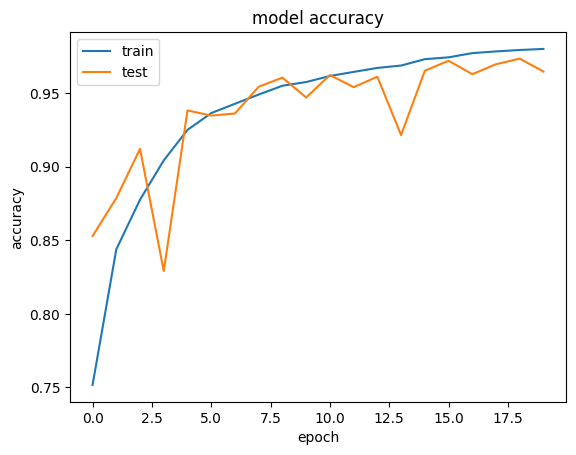

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# Intializing a sequential model
alt_lenet5_cnn = models.Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
alt_lenet5_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding="valid", input_shape=(128,128,3)))

# Adding max pooling to reduce the size of output of first conv layer
alt_lenet5_cnn.add(layers.MaxPooling2D((2, 2), padding = 'same'))

alt_lenet5_cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding="valid"))
alt_lenet5_cnn.add(layers.MaxPooling2D((2, 2), padding = 'same'))

alt_lenet5_cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding="valid"))
alt_lenet5_cnn.add(layers.MaxPooling2D((2, 2), padding = 'same'))

alt_lenet5_cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding="valid"))
alt_lenet5_cnn.add(layers.MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
alt_lenet5_cnn.add(layers.Flatten())
#drop half to prevent overfitting
alt_lenet5_cnn.add(layers.Dropout(0.5))
# Adding a fully connected dense layer with 100 neurons
alt_lenet5_cnn.add(layers.Dense(512, activation='relu'))
# Adding the output layer with * neurons and activation functions as softmax since this is a multi-class classification problem
alt_lenet5_cnn.add(layers.Dense(2, activation='softmax'))

# Compile model
# RMSprop (Root Mean Square Propagation) is commonly used in training deep neural networks.
alt_lenet5_cnn.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
alt_lenet5_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 128)      

In [14]:
#fit the model from image generator
history = alt_lenet5_cnn.fit(
            train_rescale_ds,
            batch_size=32,
            epochs=20,
            validation_data=val_rescale_ds)


Epoch 1/20
427/427 [==============================] - 94s 216ms/step - loss: 0.4759 - accuracy: 0.7862 - val_loss: 0.3558 - val_accuracy: 0.8687
Epoch 2/20
427/427 [==============================] - 94s 221ms/step - loss: 0.2717 - accuracy: 0.9049 - val_loss: 0.1944 - val_accuracy: 0.9317
Epoch 3/20
427/427 [==============================] - 95s 223ms/step - loss: 0.2023 - accuracy: 0.9249 - val_loss: 0.1415 - val_accuracy: 0.9481
Epoch 4/20
427/427 [==============================] - 98s 228ms/step - loss: 0.1609 - accuracy: 0.9389 - val_loss: 0.1232 - val_accuracy: 0.9540
Epoch 5/20
427/427 [==============================] - 99s 231ms/step - loss: 0.1321 - accuracy: 0.9508 - val_loss: 0.1047 - val_accuracy: 0.9557
Epoch 6/20
427/427 [==============================] - 100s 234ms/step - loss: 0.1242 - accuracy: 0.9524 - val_loss: 0.1075 - val_accuracy: 0.9616
Epoch 7/20
427/427 [==============================] - 94s 219ms/step - loss: 0.1104 - accuracy: 0.9570 - val_loss: 0.0901 - val_a

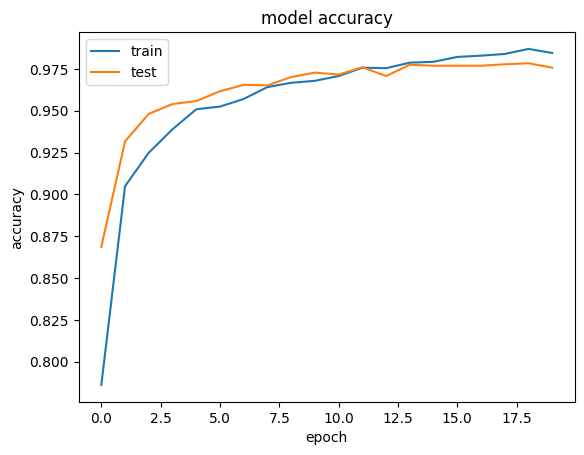

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
test_loss, test_accuracy = alt_lenet5_cnn.evaluate(test_rescale_ds, verbose=0)
test_accuracy

0.969519317150116